## Tensorflow HUB & Transfer Learning

##### Import

In [2]:
import matplotlib.pylab as plt

import tensorflow as tf

# !pip install -q -U tf-hub-nightly

import tensorflow_hub as hub
from tensorflow.keras import layers

##### MobileNet_v2 classification

In [3]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

# MobileNet V2 모델 경로

In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

# MobileNet V2 모델을 다운받아 KERAS 모델을 만듦
# MobileNet V2SMS (224,224,3)의 shape를 가짐

In [5]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


##### Test image Download

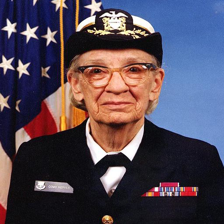

In [6]:
import numpy as np
import PIL.Image as Image

# MobileNet V2는 ImageNet 데이터 집합에 대해 교육되어 있음
# 1000개의 출력 클래스 중 군복 예측 가능한지 확인

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [7]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [8]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape
# 배치 차원 추가

In [ ]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

# argmax로 최상위 클래스 id 확인

653

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

# ImageNet에서 예측한 class가 무엇인지 확인하기 위해 ImageNet 레이블을 가져옴

24576/10484 [======================================================================] - 0s 0us/step


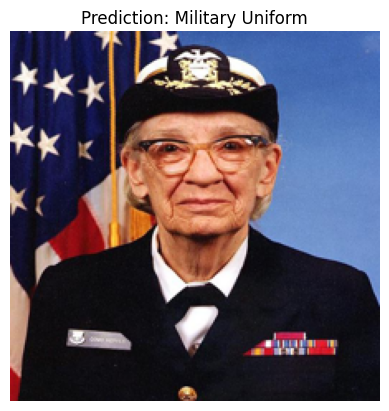

In [ ]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# 모델이 예측한 값을 가져옴

##### flower_photos dataset에 TensorFlow Hub models 사용하기

In [ ]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
# 이미지 모듈은 0과 1사이의 상수 값을 필요로 함으로 ImageDataGenerator(rescale=1/255) 적용

image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)
image_data
# folwer dataset 가져오기 

Found 3670 images belonging to 5 classes.


In [ ]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [ ]:
result_batch = classifier.predict(image_batch)
result_batch.shape

# 위에서 만든 모델에 해당 image data 적용

(32, 1001)

In [ ]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['bee', 'daisy', 'lakeside', 'lemon', 'acorn', 'daisy',
       'sunglasses', 'daisy', 'plate', 'strawberry', 'mushroom', 'daisy',
       'daisy', 'daisy', 'picket fence', 'teddy', 'bell pepper',
       'leaf beetle', 'daisy', 'viaduct', 'quill', 'hip', 'daisy',
       'castle', 'barn spider', 'daisy', 'conch', 'daisy', 'bee',
       'cardoon', 'cockroach', 'cardoon'], dtype='<U30')

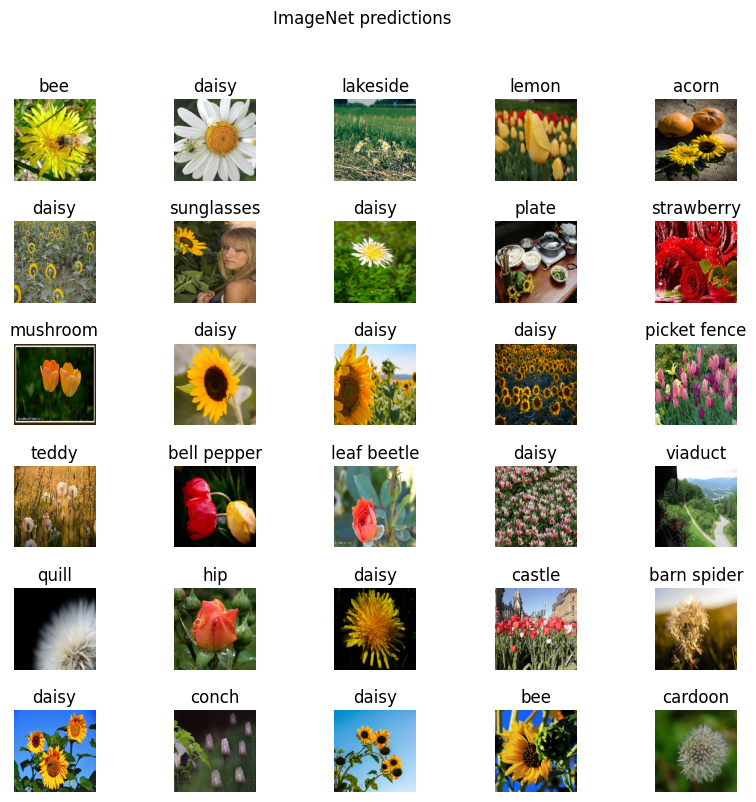

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

- TensorFlow Hub(최종 분류 계층이 없는)의 부분 모델을 feature_extrator라 함

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

In [ ]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

# 1280 : tensorflow hub에서 부분 모델 마지막 층에 있는 뉴런 수

(32, 1280)


In [ ]:
feature_extractor_layer.trainable = False

# model이 최종 분류 계층만 수정하도록 함 
# 중간 레이어들의 weight, bias는 변경하지 x

In [ ]:
image_data.num_classes

NameError: name 'image_data' is not defined

##### Set Model

In [ ]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

# model 생성
# 특징 추출된 layer만 가져오고 output으로 적용하려는 image dataset의 label수를 받음

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


##### Train Model

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [ ]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/2


C:\Users\user\AppData\Local\Temp\ipykernel_22332\645089771.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(image_data, epochs=2,


115/115 [==============================] - 11s 79ms/step - loss: 0.4876 - acc: 0.8125
Epoch 2/2
115/115 [==============================] - 7s 64ms/step - loss: 0.1967 - acc: 0.9375


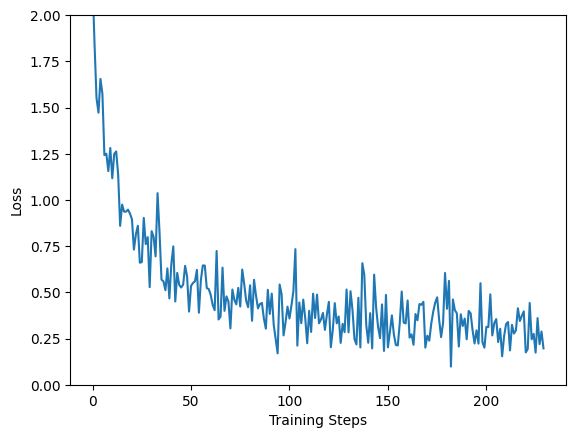

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

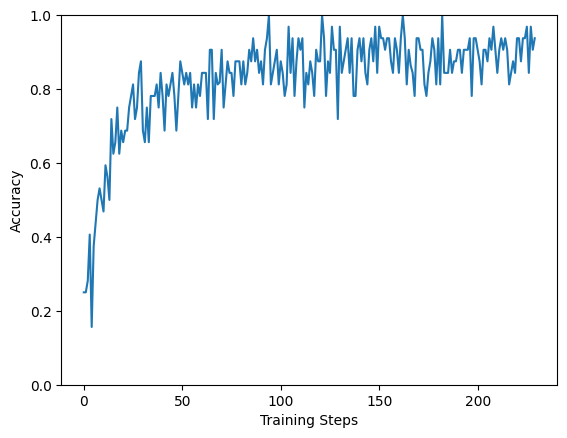

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [ ]:
image_data.class_indices.items()

dict_items([('daisy', 0), ('dandelion', 1), ('roses', 2), ('sunflowers', 3), ('tulips', 4)])

##### 예측 확인

In [ ]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
print(class_names)
class_names = np.array([key.title() for key, value in class_names])
class_names

[('daisy', 0), ('dandelion', 1), ('roses', 2), ('sunflowers', 3), ('tulips', 4)]


array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
print(predicted_id)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

# 모델을 이용해 예측한 label

[1 0 1 4 3 3 4 1 4 2 4 3 3 3 4 1 4 2 4 4 1 2 1 4 1 3 4 3 3 1 2 1]
['Dandelion' 'Daisy' 'Dandelion' 'Tulips' 'Sunflowers' 'Sunflowers'
 'Tulips' 'Dandelion' 'Tulips' 'Roses' 'Tulips' 'Sunflowers' 'Sunflowers'
 'Sunflowers' 'Tulips' 'Dandelion' 'Tulips' 'Roses' 'Tulips' 'Tulips'
 'Dandelion' 'Roses' 'Dandelion' 'Tulips' 'Dandelion' 'Sunflowers'
 'Tulips' 'Sunflowers' 'Sunflowers' 'Dandelion' 'Roses' 'Dandelion']


In [ ]:
label_id = np.argmax(label_batch, axis=-1)
label_id

# 받아온 데이터의 실제 label

array([1, 0, 0, 4, 3, 3, 3, 1, 3, 2, 4, 3, 3, 3, 4, 1, 4, 2, 4, 2, 1, 2,
       1, 4, 1, 3, 4, 3, 3, 1, 2, 1], dtype=int64)

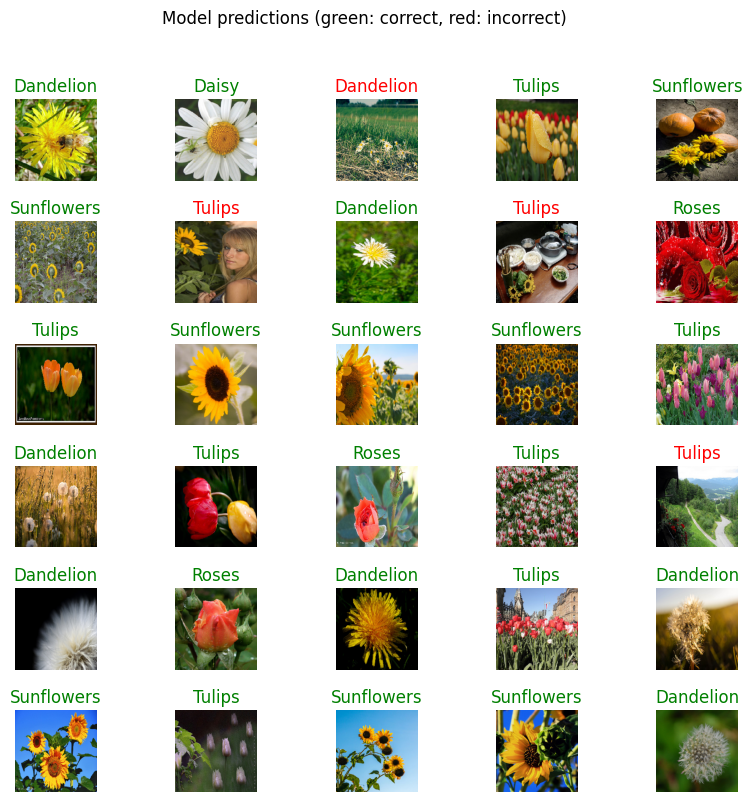

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)  # 예측 결과 출력
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Tensorflow Hub inception_v2/feature_vector 사용
- 이미지의 특징값 추출

In [ ]:
image_data
# flower data에 적용해보기

In [ ]:
extractor_url = 'https://tfhub.dev/google/imagenet/inception_v2/feature_vector/5'

feature_extractor = hub.KerasLayer(extractor_url,
                                         input_shape=(224,224,3))

In [ ]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1024)


In [ ]:
feature_extractor.trainable = False

In [ ]:
model_inceptionv2 = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model_inceptionv2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1024)              10173112  
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 10,178,237
Trainable params: 5,125
Non-trainable params: 10,173,112
_________________________________________________________________


In [ ]:
model_inceptionv2.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [ ]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history2 = model_inceptionv2.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/2


C:\Users\user\AppData\Local\Temp\ipykernel_22332\4252634009.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model_inceptionv2.fit_generator(image_data, epochs=2,


115/115 [==============================] - 12s 81ms/step - loss: 0.4780 - acc: 0.7812
Epoch 2/2
115/115 [==============================] - 7s 60ms/step - loss: 0.5503 - acc: 0.7188


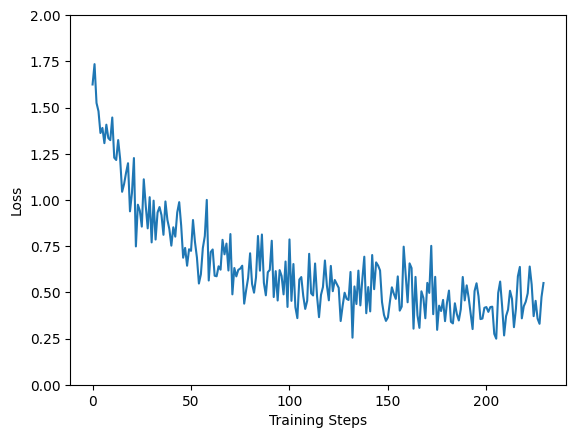

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

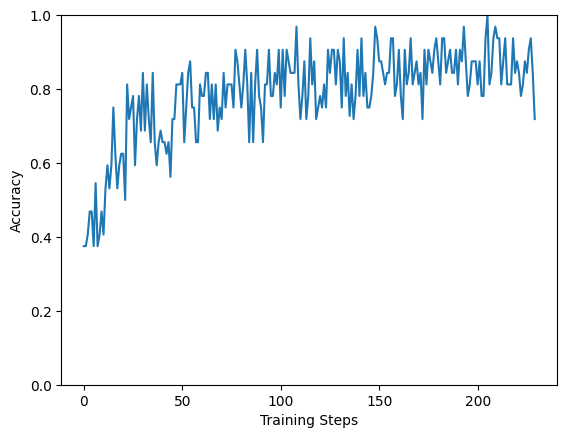

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [ ]:
predicted_batch = model_inceptionv2.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
print(predicted_id)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

[1 0 0 4 4 3 4 1 2 2 4 0 3 3 4 4 4 4 4 4 1 4 1 4 1 3 4 3 3 1 2 1]
['Dandelion' 'Daisy' 'Daisy' 'Tulips' 'Tulips' 'Sunflowers' 'Tulips'
 'Dandelion' 'Roses' 'Roses' 'Tulips' 'Daisy' 'Sunflowers' 'Sunflowers'
 'Tulips' 'Tulips' 'Tulips' 'Tulips' 'Tulips' 'Tulips' 'Dandelion'
 'Tulips' 'Dandelion' 'Tulips' 'Dandelion' 'Sunflowers' 'Tulips'
 'Sunflowers' 'Sunflowers' 'Dandelion' 'Roses' 'Dandelion']


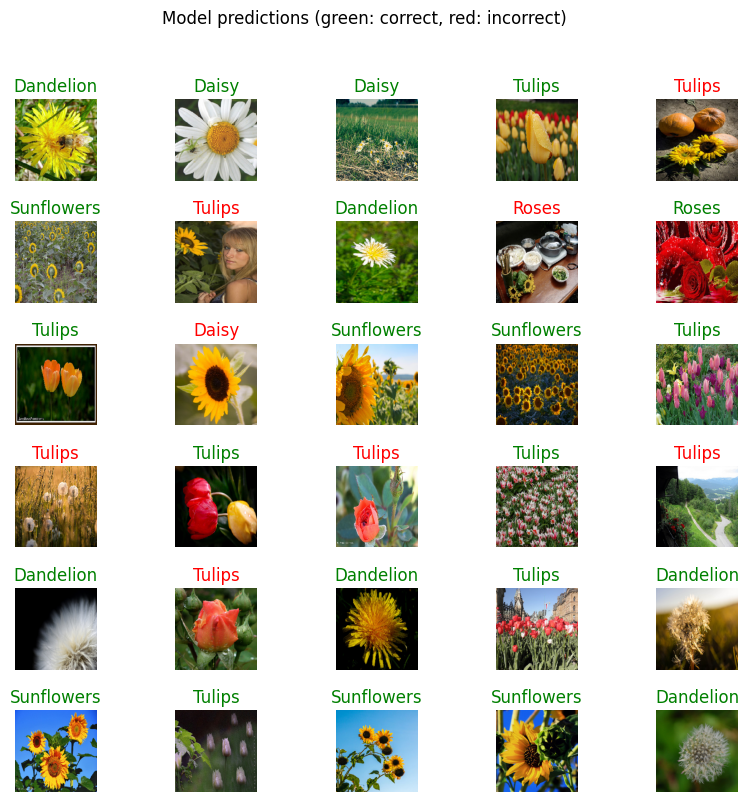

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)  # 예측 결과 출력
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

### mobilenet_v2/feature_vector와 inception_v2/feature_vector 비교
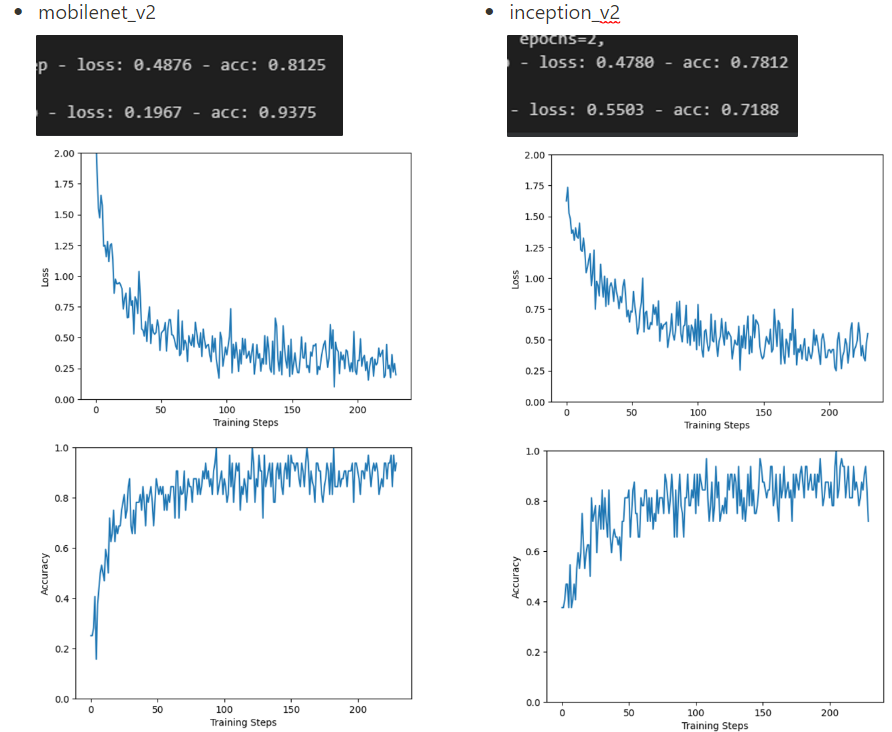
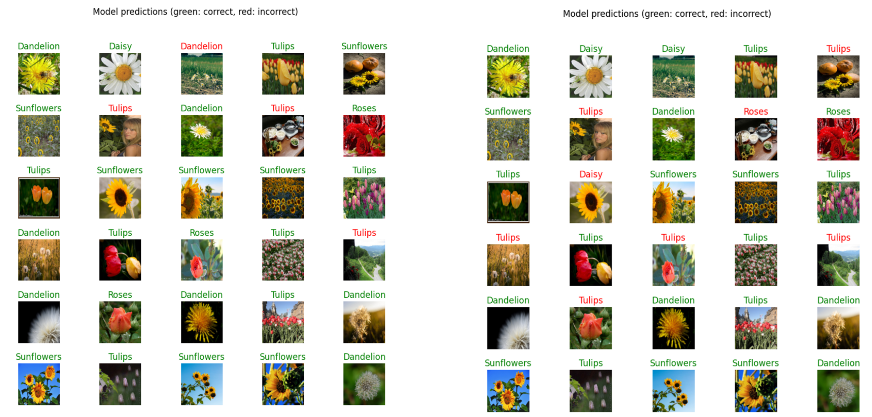
- 다음과 같이 inception_v2의 정확도와 loss 값이 mobilenet_v2 보다 좋지 못한 성능이 나왔음
- folwer dataset에 적용해 본 결과 incorrect 분포가 더 많은 것을 확인 할 수 있음

##### 모델 추출

In [ ]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

In [ ]:
reloaded = tf.keras.models.load_model(export_path)

In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
abs(reloaded_result_batch - result_batch).max()